# 横场伊辛模型
## 主程序 0 ：基网络的搭建与训练，采用硬件高效拟设 (HEA)

In [1]:
import numpy as np
import mindspore as ms
from mindquantum import *
import matplotlib.pyplot as plt
from rich.progress import *

ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
np.random.seed(1)

def ham(qubit_num): # 根据模型，生成系统哈密顿量
    ham =QubitOperator(f'Z{0} Z{qubit_num-1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'Z{i} Z{i+1}', -1)
    for i in range(qubit_num):
        ham += QubitOperator(f'X{i}',-2)
    return [Hamiltonian(ham)]

def base_net(first_qubit=0, base_qubit_num=4, base_layer_num=1, base_net=0): # 生成基网络
    circ = Circuit()
    for layer in range(base_layer_num):
        for qubit in range(base_qubit_num):
            circ += RZ(para_names[int(3 * base_net * base_qubit_num * base_layer_num + 3 * layer  * base_qubit_num + 3 * qubit + 0)]).on(qubit + first_qubit)
            circ += RX(para_names[int(3 * base_net * base_qubit_num * base_layer_num + 3 * layer  * base_qubit_num + 3 * qubit + 1)]).on(qubit + first_qubit)
            circ += RZ(para_names[int(3 * base_net * base_qubit_num * base_layer_num + 3 * layer  * base_qubit_num + 3 * qubit + 2)]).on(qubit + first_qubit)

        for i in range(first_qubit, first_qubit + base_qubit_num - 1):
            circ += Z.on(i+1, i)
        circ += Z.on(first_qubit, first_qubit + base_qubit_num - 1)

    return circ

base_qubit_num = 4 # 基网络的比特数
base_layer_num = 4 # 基网络的层数
qubit_num = 4 # 目标网络的比特数，此处设为和基网络一致，得到的结果，就是基网络的结果
base_net_num = qubit_num - base_qubit_num + 1 # 目标网络中所含基网络的数量
hamiltonian = ham(qubit_num) # 生成系统总的哈密顿量，此处是基网络的哈密顿量

sample_num = 100 # 最后要对多次训练结果进行分析，设置采样次数
para_names = np.array(range(base_net_num * 3 * base_qubit_num * base_layer_num)).astype(str) # 生成目标网络中所有参数的名字

base = Circuit() # 基网络
base += base_net(first_qubit=0, base_qubit_num=base_qubit_num, base_layer_num=base_layer_num, base_net=0)

sim = Simulator('mqvector', base.n_qubits)
grad_ops = sim.get_expectation_with_grad(hamiltonian, base)

paras_list = [] # 参数保存
with Progress() as progress:
    task = progress.add_task("[red]Sampling", total=sample_num)
    for num in range(sample_num): # 采样多次
        net = MQAnsatzOnlyLayer(grad_ops)   # 搭建网络
        opti = ms.nn.Adam(net.trainable_params(), learning_rate=0.05)    # 优化器
        train_net = ms.nn.TrainOneStepCell(net, opti)  # 调用一次，就训练一次
        # print('\n初始期望值为：',train_net()[0])

        for i in range(200): # 训练 200 个回合，已足够收敛
            train_net()

        # print('最终期望值为!', train_net()[0])
        paras_list.append(net.weight.asnumpy()) # 保存收敛后的基网络参数
        progress.update(task, advance=1)
base_net_paras = np.array(paras_list)
print('\n收敛参数为：\n', base_net_paras.shape)

np.save('./src/Ising_base_net_paras.npy', base_net_paras)  # 导出数据
print('\n导出完成啦!')

# a = np.load('./src/Ising_base_net_paras.npy', allow_pickle=True) # 重新导入，以检验
# print('\n检验参数维度为：\n', a.shape)

[WARNING] ME(12141:140570583761728,MainProcess):2023-10-17-23:06:10.420.248 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.2.72 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


Output()


收敛参数为：
 (100, 48)

导出完成啦!


## 主程序 1： 采用网络迁移方法构建的目标网络，当参数随机初始化，不同尺寸网络中，首个有效参数的梯度方差的变化情况

Output()

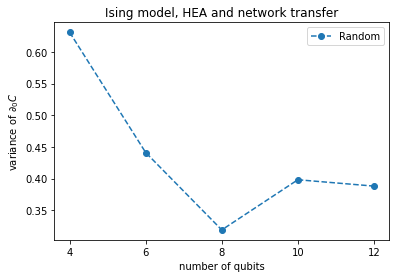

In [3]:
from mindquantum import *
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

def ham(qubit_num):
    ham =QubitOperator(f'Z{0} Z{qubit_num-1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'Z{i} Z{i+1}', -1)
    for i in range(qubit_num):
        ham += QubitOperator(f'X{i}',-2)
    return [Hamiltonian(ham)]

def base_net(first_qubit=0, base_qubit_num=4, base_layer_num=1, base_net=0):
    circ = Circuit()
    for layer in range(base_layer_num):
        for qubit in range(base_qubit_num):
            circ += RZ(para_names[int(3 * base_net * base_qubit_num * base_layer_num + 3 * layer  * base_qubit_num + 3 * qubit + 0)]).on(qubit + first_qubit)
            circ += RX(para_names[int(3 * base_net * base_qubit_num * base_layer_num + 3 * layer  * base_qubit_num + 3 * qubit + 1)]).on(qubit + first_qubit)
            circ += RZ(para_names[int(3 * base_net * base_qubit_num * base_layer_num + 3 * layer  * base_qubit_num + 3 * qubit + 2)]).on(qubit + first_qubit)

        for i in range(first_qubit, first_qubit + base_qubit_num - 1):
            circ += Z.on(i+1, i)
        circ += Z.on(first_qubit, first_qubit + base_qubit_num - 1)
    return circ

def get_var(circuit,  hamiltonian, sample_num = 10):
    simulator = Simulator('mqvector', circuit.n_qubits)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)

    avg_var = 0
    for i in range(sample_num):
        random_paras = np.random.rand(len(circuit.params_name))*2*np.pi
        avg_var += grad_ops(random_paras)[1][0,0,1].real**2 / sample_num
    return avg_var

base_qubit_num = 4
base_layer_num = 4

avg_var_list = []
with Progress() as progress:
    task = progress.add_task("[green]qubit_num",
                             total=len(range(4, 12 + 1, 2)))
    for qubit_num in range(4, 12+1, 2): # 比特范围为 4 到 12
        base_net_num = qubit_num-base_qubit_num+1
        hamiltonian = ham(qubit_num)
        para_names = np.array(range(base_net_num * 3 * base_qubit_num * base_layer_num)).astype(str)

        ansatz = Circuit()
        for i in range(0, base_net_num):
            ansatz += base_net(first_qubit=i, base_qubit_num=base_qubit_num, base_layer_num=base_layer_num, base_net=i)

        avg_var = get_var(ansatz, hamiltonian, sample_num=100)
        avg_var_list.append(avg_var)
        progress.update(task, advance=1)
plt.figure()
plt.plot(avg_var_list, label = 'Random', linestyle='--', marker='o') # 画出训练过程中，验证集分类准确度的变化情况
plt.title('Ising model, HEA and network transfer', fontsize=12)
plt.legend()
plt.xlabel('number of qubits', fontsize=10)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[4, 6, 8, 10, 12])
plt.ylabel(r'variance of $\partial_0C$ ', fontsize=10)
plt.savefig('./src/Fig3a.png')
plt.show()

上图即是论文中 图 3 a，可见结果和论文结论一致。
## 主程序 2 ：采用网络迁移搭建的目标网络，采用基网络最优参数和随机参数，在不同尺寸下的正则化梯度范数变化情况。

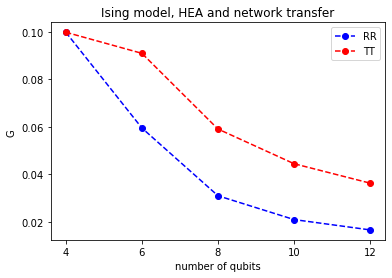

In [4]:
from mindquantum import *
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

def ham(qubit_num):
    ham =QubitOperator(f'Z{0} Z{qubit_num-1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'Z{i} Z{i+1}', -1)
    for i in range(qubit_num):
        ham += QubitOperator(f'X{i}',-2)
    return [Hamiltonian(ham)]

def base_net(first_qubit=0, base_qubit_num=4, base_layer_num=1, base_net=0):
    circ = Circuit()
    for layer in range(base_layer_num):
        for qubit in range(base_qubit_num):
            circ += RZ(para_names[int(3 * base_net * base_qubit_num * base_layer_num + 3 * layer  * base_qubit_num + 3 * qubit + 0)]).on(qubit + first_qubit)
            circ += RX(para_names[int(3 * base_net * base_qubit_num * base_layer_num + 3 * layer  * base_qubit_num + 3 * qubit + 1)]).on(qubit + first_qubit)
            circ += RZ(para_names[int(3 * base_net * base_qubit_num * base_layer_num + 3 * layer  * base_qubit_num + 3 * qubit + 2)]).on(qubit + first_qubit)

        for i in range(first_qubit, first_qubit + base_qubit_num - 1):
            circ += Z.on(i+1, i)
        circ += Z.on(first_qubit, first_qubit + base_qubit_num - 1)
    return circ

def get_random_gra_norm(circuit,  hamiltonian, sample_num = 10):
    simulator = Simulator('mqvector', circuit.n_qubits)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    gra_num = len(circuit.params_name)
    avg_gra_norm = 0
    for i in range(sample_num):
        gra_norm = 0
        random_paras = np.random.rand(len(circuit.params_name))*2*np.pi
        for j in range(gra_num):
            gra_norm += grad_ops(random_paras)[1][0,0,j].real**2
        gra_norm = np.sqrt(gra_norm) / gra_num
        avg_gra_norm += gra_norm / sample_num
    return avg_gra_norm

def get_trans_gra_norm(circuit,  hamiltonian, sample_num = 10):
    simulator = Simulator('mqvector', circuit.n_qubits)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    gra_num = len(circuit.params_name)
    avg_gra_norm = 0
    for i in range(sample_num):
        gra_norm = 0
        paras = np.array([])
        if base_net_num == 1:
            paras = np.random.rand(len(circuit.params_name))*2*np.pi
        else:
            for _ in range(base_net_num):
                paras = np.append(paras, base_net_paras[i])

        for j in range(gra_num):
            gra_norm += grad_ops(paras)[1][0,0,j].real**2

        gra_norm = np.sqrt(gra_norm) / gra_num
        avg_gra_norm += gra_norm / sample_num
    return avg_gra_norm

base_qubit_num = 4
base_layer_num = 4
sample_num = 100
base_net_paras = np.load('./src/Ising_base_net_paras.npy', allow_pickle=True)

# 先计算 4 比特的基网络
hamiltonian = ham(qubit_num=base_qubit_num)
para_names = np.array(range(1 * 3 * base_qubit_num * base_layer_num)).astype(str)
base =  base_net(first_qubit=0, base_qubit_num=base_qubit_num, base_layer_num=base_layer_num, base_net=0)
avg_base_gra_norm =get_random_gra_norm(base, hamiltonian, sample_num=sample_num)

avg_random_gra_norm_list = [avg_base_gra_norm]
avg_trans_gra_norm_list = [avg_base_gra_norm]

for qubit_num in range(5, 12+1, 2): # 比特范围为 4 到 12
    base_net_num = qubit_num-base_qubit_num+1
    hamiltonian = ham(qubit_num)
    para_names = np.array(range(base_net_num * 3 * base_qubit_num * base_layer_num)).astype(str)

    ansatz = Circuit()
    for i in range(0, base_net_num):
        ansatz += base_net(first_qubit=i, base_qubit_num=base_qubit_num, base_layer_num=base_layer_num, base_net=i)

    avg_gra_norm = get_random_gra_norm(ansatz, hamiltonian, sample_num=sample_num)
    avg_random_gra_norm_list.append(avg_gra_norm)

for qubit_num in range(5, 12+1, 2): # 比特范围为 4 到 12
    base_net_num = qubit_num-base_qubit_num+1
    hamiltonian = ham(qubit_num)
    para_names = np.array(range(base_net_num * 3 * base_qubit_num * base_layer_num)).astype(str)

    ansatz = Circuit()
    for i in range(0, base_net_num):
        ansatz += base_net(first_qubit=i, base_qubit_num=base_qubit_num, base_layer_num=base_layer_num, base_net=i)

    avg_trans_gra_norm =get_trans_gra_norm(ansatz, hamiltonian, sample_num=sample_num)
    avg_trans_gra_norm_list.append(avg_trans_gra_norm)

plt.figure()
plt.plot(avg_random_gra_norm_list, label = 'RR', linestyle='--', marker='o', color='b') # 画出基网络随机初始参数的平均正则化导数随比特数的变化
plt.plot(avg_trans_gra_norm_list, label = 'TT', linestyle='--', marker='o', color='r') # 画出基网络迁移最优初始参数的平均正则化导数随比特数的变化
plt.title('Ising model, HEA and network transfer', fontsize=12)
plt.legend()
plt.xlabel('number of qubits', fontsize=10)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[4, 6, 8, 10, 12])
plt.ylabel('G ', fontsize=10)
plt.savefig('./src/Fig3d.png')
plt.show()

上图就是论文 图 3 d。复现结果和论文结论一致。

In [5]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum')

Software,Version
mindquantum,0.9.0
System,Info
Python,3.9.7
OS,Linux x86_64
Memory,16.71 GB
CPU Max Thread,8
Date,Tue Oct 17 23:21:59 2023
